In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import matplotlib.colors as mcolors
import pandas as pd


In [2]:
#%%
# Plotter Function


#Magnet Design

#pars_magnet = pd.read_csv('/afs/cern.ch/user/g/gfrisell/cernbox/sc_v6_params.csv')

pars_magnet = pd.read_csv('Trial2.csv')

# Ensure 'Entrance' and 'Exit' columns are created
pars_magnet["Entrance"] = pars_magnet["Z_pos(cm)"]  # or any initial value you prefer
pars_magnet["Exit"] = pars_magnet["Z_pos(cm)"]  # same here for Exit column


offset_target = 1.44
for items in pars_magnet:
    if items.endswith('(cm)'):
        #print(pars_magnet[items])
        
        pars_magnet[items] = pars_magnet[items] /100
for items in range(0,len(pars_magnet)):
    # Entrance positions for all magnets
    pars_magnet.loc[items, "Entrance"] = pars_magnet.loc[items, "Z_pos(cm)"] + ( offset_target if items == 0 else 0) + (pars_magnet.loc[items-1, "Exit"] if items > 0 else 0)
    pars_magnet.loc[items,"Exit"] = pars_magnet.loc[items,"Entrance"] + pars_magnet.loc[items,"Z_len(cm)"]

#print(f'the magnet desing:\n {pars_magnet})')


class ParticlePlotterino:
    def __init__(self, X, Y, Z, P, Pdg, magnet_pars=None, **kgwargs_args):
        """
        Initializes the ParticlePlotter with particle data and magnet parameters.

        Parameters:
            X (list or array): List of X positions.
            Y (list or array): List of Y positions.
            Z (list or array): List of Z positions.
            P (list or array): List of momentum values.
            magnet_pars (dict, optional): Dictionary containing magnet parameters.
        """
        self.X = X
        self.Y = Y
        self.Z = Z
        self.Z_keys = list(self.Z.keys())  
        self.P = P
        self.Pdg = Pdg
        self.magnet_pars = magnet_pars
        self.sensitive_plane = 83.99
        self.survived_count = len(self.X)
        
        # Define cavern walls
        self.wall_z = np.linspace(0, 100, 10000)
        self.wall_x_up = np.concatenate((np.zeros(1800) + 6.43, np.zeros(8200) + 11.43))
        self.wall_x_dw = np.concatenate((np.zeros(1800) - 3.56, np.zeros(8200) - 4.56))
        self.wall_y_up = np.concatenate((np.zeros(1800) + 5.8, np.zeros(8200) + 8.64))
        self.wall_y_dw = np.concatenate((np.zeros(1800) - 1.7, np.zeros(8200) - 3.36))
        
    def plot_section(self, option='x', option2='P', disc = []):
        """
        Plots a section (Z vs. X or Z vs. Y) for the particles in data, with magnet boundaries.
        
        Parameters:
            option (str): Either 'x' for Z vs. X, or 'y' for Z vs. Y.
        """
        fig, ax = plt.subplots(figsize=(10, 6))

        # Flags for adding labels only once
        particle_label_added = False
        magnet_label_added = False

        # Create a colormap
        cmap = plt.get_cmap('tab20b')

        # Plot Z vs X or Z vs Y based on the option selected
        if option == 'x':
            x_positions = self.X
            wall_up = self.wall_x_up
            wall_dw = self.wall_x_dw
            label_str = ['Xyoke1(cm)', 'Xyoke2(cm)']
            ax.set_ylabel('X Position (m)')
            ax.set_title('Z vs. X Distribution')
        elif option == 'y':
            x_positions = self.Y
            wall_up = self.wall_y_up
            wall_dw = self.wall_y_dw
            label_str = ['Yyoke1(cm)', 'Yyoke2(cm)']
            ax.set_ylabel('Y Position (m)')
            ax.set_title('Z vs. Y Distribution')

        
        if option2 == 'P':
            self.last_values = [v[0] for v in P.values()]
            norm_values = (self.last_values - np.min(self.last_values)) / (np.max(self.last_values) - np.min(self.last_values))
        elif option2 == 'q':
            self.last_values = [v/13 for v in Pdg.values()]
            norm_values = [v  for v in self.last_values]
        elif option2 == 'discriminant' and disc:
            if isinstance(disc, list) and not all(el in [True, False] for el in disc):
                    # Create a new list that will store True/False for each name in the small list
                disc = [name in self.Z_keys for name in disc]
            self.last_values = np.array(disc).astype(int)
            norm_values = np.array(disc).astype(int)
            
        cmap = plt.get_cmap("tab20b")  # Choose a colormap
        self.colors = cmap(norm_values)  # Map normalized values to colormap
        if len(Z)<100:
            self.index = np.linspace(0,len(self.P)-1,len(Z)-1,dtype=int)
        else:
            self.index = np.linspace(0,len(self.P)-1,100,dtype=int)
            
        #self.index = np.linspace(0,len(self.P)-1,len(Z)-1,dtype=int)


        self.keys = np.array(list(self.P.keys()))[self.index]   # Convert keys to a NumPy array
        
        temp2=[]
        for key in self.keys: 
            temp2.append(P[key][0])
        self.max_P0 = max(temp2)
        self.min_P0 = min(temp2)
        # Plot Z vs. X/Y positions for particles
        for key in self.keys:
            if option2 == 'discriminant':
                if norm_values[i] >0:
                    ax.plot(self.Z[key], x_positions[key], 'x--', alpha=1, color= 'r')
                else:
                    ax.plot(self.Z[key], x_positions[key], 'x--', alpha=1, color= 'b') 
            else: 
                norm_value = np.clip((P[key][0] - self.min_P0) / (self.max_P0 - self.min_P0), 0, 1)  # Adjust scaling based on your data range
                color = cmap(norm_value)  # Get the RGBA color
                ax.plot(self.Z[key], x_positions[key], 'x--', alpha=1, color=color)


        # Plot magnet boundaries
        if self.magnet_pars is not None:
            for idx in self.magnet_pars.index:
                if self.magnet_pars.loc[idx,'Xcore1(cm)'] == 0:
                    continue
                # Draw the entrance and exit lines of the magnet
                entrance = self.magnet_pars.loc[idx, 'Entrance']
                exit = self.magnet_pars.loc[idx, 'Exit']
                
                if not magnet_label_added:
                    # Entrance and exit lines for the first magnet
                    ax.plot(
                        [entrance, entrance],
                        [self.magnet_pars.loc[idx, label_str[0]], -self.magnet_pars.loc[idx, label_str[0]]],
                        color='red', linestyle='--', linewidth=1.5, label='Magnet'
                    )
                    magnet_label_added = True
                else:
                    ax.plot(
                        [entrance, entrance],
                        [self.magnet_pars.loc[idx, label_str[0]], -self.magnet_pars.loc[idx, label_str[0]]],
                        color='red', linestyle='--', linewidth=1.5
                    )

                # Plot the magnet's exit lines
                ax.plot(
                    [exit, exit],
                    [self.magnet_pars.loc[idx, label_str[1]], -self.magnet_pars.loc[idx, label_str[1]]],
                    color='red', linestyle='--', linewidth=1.5
                )
                ax.plot(
                    [entrance, exit],
                    [self.magnet_pars.loc[idx, label_str[0]], self.magnet_pars.loc[idx, label_str[1]]],
                    color='red', linestyle='--', linewidth=1.5
                )
                ax.plot(
                    [entrance, exit],
                    [-self.magnet_pars.loc[idx, label_str[0]], -self.magnet_pars.loc[idx, label_str[1]]],
                    color='red', linestyle='--', linewidth=1.5
                )
                
                if option == 'x':
                #Plot the gaps
                    ax.plot(
                        [entrance, exit],
                        [self.magnet_pars.loc[idx, 'Xvoid1(cm)'], self.magnet_pars.loc[idx, 'Xvoid2(cm)']],
                        color='red', linestyle='--', linewidth=1.5
                    )
                    ax.plot(
                        [entrance, exit],
                        [-self.magnet_pars.loc[idx, 'Xvoid1(cm)'], -self.magnet_pars.loc[idx, 'Xvoid2(cm)']],
                        color='red', linestyle='--', linewidth=1.5
                    )
                    ax.plot(
                        [entrance, exit],
                        [self.magnet_pars.loc[idx, 'Xcore1(cm)'], self.magnet_pars.loc[idx, 'Xcore2(cm)']],
                        color='red', linestyle='--', linewidth=1.5
                    )
                    ax.plot(
                        [entrance, exit],
                        [-self.magnet_pars.loc[idx, 'Xcore1(cm)'], -self.magnet_pars.loc[idx, 'Xcore2(cm)']],
                        color='red', linestyle='--', linewidth=1.5
                    )
                
        # Plot cavern walls
        ax.plot(self.wall_z, wall_up, 'b-', linewidth=2, label="Cavern Wall")
        ax.plot(self.wall_z, wall_dw, 'b-', linewidth=2)
        
        # Plot the sensitive plane
        ax.axvline(x=83.79, color='g', linestyle='--', label='Sensitive Plane')
        
        #Plot the Tr station
        ax.axvline(x=84, color='r', linestyle='--', label='Tr Station')
        ax.axvline(x=86, color='r', linestyle='--')
        ax.axvline(x=91.4, color='r', linestyle='--')
        ax.axvline(x=93.4, color='r', linestyle='--')
        
        # Add a colorbar to show the color mapping
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=self.min_P0, vmax=self.max_P0))
        sm.set_array([])  # We don't need data for the colorbar
        
        if option2 == 'P':
            cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
            cbar.set_label('Initial Momentum P0 [Gev/c]')  # Label for the colorbar
            ax.legend()
        else:
            # Create the legend entry for the negative charge (min value)
            negative_patch = mpatches.Patch(color=cmap(-1), label='Negative Charge -1e')
            positive_patch = mpatches.Patch(color=cmap(1000), label='Positive Charge 1e')

            # Add the legend to the plot
            ax.legend(handles=[negative_patch,positive_patch])



        
        ax.set_xlabel('Z Position (m)')

        # Set the plot limits
        ax.set_ylim(-4.56, 4.56)
        ax.set_xlim(0, 100)

        # Enable grid for better readability
        ax.grid(True)

        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()

    def plot_momenta(self):
        """
        Plots the momenta of particles near the specified z positions.
        """
        fig, ax = plt.subplots(figsize=(8, 6))
        cmap = plt.get_cmap("tab20b")  # Choose a colormap
        temp=0
        
        for key in self.keys:
            norm_value = np.clip((P[key][0] - self.min_P0) / (self.max_P0 - self.min_P0), 0, 1)
            color = cmap(norm_value)  # Get the RGBA color
            if temp ==0:
                ax.plot(self.Z[key], self.P[key], 'x--', alpha=1, color=color, label='Particle Momentum')
                temp=1
            else:
                ax.plot(self.Z[key], self.P[key], 'x--', alpha=1, color=color)
        
        #Plot the Tr station
        ax.axvline(x=84, color='r', linestyle='--', label='Tr Station')
        ax.axvline(x=86, color='r', linestyle='--')
        ax.axvline(x=91.4, color='r', linestyle='--')
        ax.axvline(x=93.4, color='r', linestyle='--')
        
        # Add a colorbar to show the color mapping
        #sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=80))
        #sm.set_array([])  # We don't need data for the colorbar
        #cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
        #cbar.set_label('P [Gev/c]')  # Label for the colorbar 

        # Add legend, labels, and finalize the plot
        ax.legend()
        ax.set_ylabel('P momenta [GeV/c]')
        ax.set_title('Z vs. P Distribution')
        ax.set_xlabel('Z Position [m]')
         # Set the plot limits
        #ax.set_ylim(-4.5, 4.5)
        ax.set_xlim(0, 100)


        # Enable grid for better readability
        ax.grid(True)

        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()




# %%

In [3]:
class Plotter:
    def __init__(self, X, Y, Z, W, P, P0, total_entries, n_tot=411947589, cut=[0,400]):
        # Initialize the class with the provided data
        self.P0 = P0
        self.cut = cut
        
        mask = np.where((self.P0 > self.cut[0]) & (self.P0 < self.cut[1]))[0]
        
        self.X = X[mask]
        self.Y = Y[mask]
        self.Z = Z[mask]
        self.W = W[mask]
        self.P = P[mask]
        self.P0 = P0[mask]
        self.total_entries = total_entries
        self.n_tot = n_tot
        
        # Retrieve statistics of the sample
        number_events_processed = sum(self.total_entries.values())
        number_particle = len(self.P)
        mean_x = np.mean(self.X)
        mean_y = np.mean(self.Y)
        sum_weight = np.sum(self.W)
        self.sum_squared_weight = np.sum(self.W**2)
        attenuation_factor = number_particle / number_events_processed
        self.normalization_factor = self.n_tot / number_events_processed
        self.rate = sum_weight * self.normalization_factor
        
        print(f'Number of events processed: {number_events_processed:.0f}')
        print(f'Rate of events processed: {number_events_processed / self.n_tot:.2f}')
        print(f"Number of particles: {number_particle:.0f}")
        print(f"Mean of X:  {mean_x:.2f} m")
        print(f"Mean of Y:  {mean_y:.2f} m")
        print(f"Sum of W:  {sum_weight:.0f}")
        print(f"Attenuation factor:  {attenuation_factor:.1e}")
        print(f"Rate P0 = [{self.cut[0]},{self.cut[1]}] GeV/c: {self.rate/1000:.0f} ± {np.sqrt(self.sum_squared_weight)/1000:.0f} kHz")
       
    def Statistic(self, ax, legend = True, option=''):
        
        stats_text = (f"P0 = [{self.cut[0]},{self.cut[1]}] GeV/c\n"
                      f"Particles: {len(self.P)}\n"
                      f'Rate of events processed: {sum(self.total_entries.values()) / self.n_tot:.2e}\n'
                      f"Rate: {self.rate/1e3:.2f}± {np.sqrt(self.sum_squared_weight)/1e3:.2f} kHz")
        
        if option=='Coordinates':
             stats_text = (f"Particles: {len(self.P)}\n"
                           f"P0 = [{self.cut[0]},{self.cut[1]}] GeV/c\n"
                           f"Mean X: {np.mean(self.X):.2f} m\n"
                           f"Mean Y: {np.mean(self.Y):.2f} m")
        
        ax.plot([], [], ' ', label=stats_text)
        #plt.xlabel('Momentum [GeV/c]' if option == 'P' else 'Transverse Position [m]')
        #plt.ylabel('Frequency')
        if legend:
            plt.legend()
        #plt.show()
        
        return
     
    def scatter(self, label='', legend = True):

        

        # Initialize the plot
        fig, ax = plt.subplots(figsize=(8, 6))
        sc = ax.scatter(self.X, self.Y, c=self.P, marker='o', label='Particle Position')
        cbar = plt.colorbar(sc, ax=ax)
        cbar.set_label("Final Particle Momentum [GeV/c]" + (label if label else ''))

        ax.set_xlabel('X [m]')
        ax.set_ylabel('Y [m]')
        ax.set_title(f'Particles transverse distribution' + (label if label else ''))
        ax.grid(True)
        ax.legend()
        
        self.Statistic( ax, legend = legend)

        plt.show()
        
        return

    def Histogram_Coordiantes(self, label='', legend = True):
        
        fig, ax = plt.subplots(figsize=(8, 6))
        num_bins = 20
        x_bins = np.linspace(np.min(self.X), np.max(self.X), num_bins + 1)
        y_bins = np.linspace(np.min(self.Y), np.max(self.Y), num_bins + 1)
        bins = x_bins if x_bins[0] < y_bins[0] else y_bins
        
        # Compute bin centers and shift
        bin_centers = (bins[:-1] + bins[1:]) / 2
        shift = (bins[1] - bins[0]) * 0.2

        hist_y, _ = np.histogram(self.Y, bins=bins)
        hist_x, _ = np.histogram(self.X, bins=bins)

        

        ax.bar(bin_centers - shift, hist_x, width=(bins[1] - bins[0]) * 0.4, alpha=0.7, label='X', color='r', align='center')
        ax.bar(bin_centers + shift, hist_y, width=(bins[1] - bins[0]) * 0.4, alpha=0.7, label='Y', color='black', align='center')

       

        ax.set_xlabel('Transverse Position [m]')
        ax.set_title('Histogram of transverse coordinates X and Y'+ label)
        
        self.Statistic( ax, legend = legend, option='Coordinates')
        
        plt.show()
        
        return
        

    def Histogram_Momenta_unweigthed(self, label=[], legend = True):
        
        fig, ax = plt.subplots(figsize=(8, 6))
        #binss = 30
        num_bins = 20
        x_bins = np.linspace(np.min(self.P0), np.max(self.P0), num_bins + 1)
        y_bins = np.linspace(np.min(self.P), np.max(self.P), num_bins + 1)
        bins = x_bins if x_bins[0] < y_bins[0] else y_bins
        
        # Compute bin centers and shift
        bin_centers = (bins[:-1] + bins[1:]) / 2
        shift = (bins[1] - bins[0]) * 0.2
        
        hist_p0, _ = np.histogram(self.P0, bins=bins)
        hist_p, _ = np.histogram(self.P, bins=bins)
        
        if len(self.P) - sum(hist_p)!= 0:
            print(len(self.P) - sum(hist_p))
            hist_p[0] += len(self.P) - sum(hist_p)

        ax.bar(bin_centers - shift, hist_p, width=(bins[1] - bins[0]) * 0.4, alpha=0.7, label='Final Momentum', color='r', align='center')
        ax.bar(bin_centers + shift, hist_p0, width=(bins[1] - bins[0]) * 0.4, alpha=0.7, label='Initial Momentum', color='blue', align='center')
        #ax.text( 0.1, 0.1, f'{x_bins[0]:.2f}', color='black', fontsize=8, ha='center', va='bottom')
    
        ax.set_yscale('log')
        ax.set_title('Momentum Distribution unweighted' + (label if label else '') + f' P0=[{self.cut[0],self.cut[1]}]')
        ax.minorticks_on()



        self.Statistic( ax, legend = legend)
        
        plt.show()

        return

    
    
    def Histogram_weight(self, label = '', legend = True):

        # Define bins
        bin_edges = np.linspace(min(self.P), max(self.P), num=30)
    
        # Find bin indices
        bin_indices = np.digitize(self.P, bin_edges, right=False)
        
        # Initialize arrays
        bin_weights_sum = np.zeros(len(bin_edges) - 1)
        bin_weights_error = np.zeros(len(bin_edges) - 1)  # Error = sqrt(sum of weights in bin)

        # Sum the weights and compute errors
        for i in range(len(bin_edges) - 1):
            bin_mask = bin_indices == (i + 1)  # Mask for values in this bin
            bin_weights_sum[i] = np.sum(self.W[bin_mask]*self.normalization_factor)
            bin_weights_error[i] = np.sqrt((np.sum(self.W[bin_mask]*self.normalization_factor)**2))  # Error as sqrt(sum of weights^2)
    
        # Compute cumulative sum for annotation
        cumulative_sum = np.cumsum(bin_weights_sum)
        print(' sum:',np.sum(bin_weights_sum))
        print(bin_edges)
        print(bin_weights_sum)
        # Plotting
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Plot histogram with error bars
        ax.bar(bin_edges[:-1], bin_weights_sum, edgecolor='black', width=np.diff(bin_edges), align='edge', color='orange', alpha=0.7, label ="Rate [Hz]" ) #label=stats_text)
    
        ax.errorbar(bin_edges[:-1] + np.diff(bin_edges) / 2, bin_weights_sum, yerr=bin_weights_error, fmt='k.', capsize=3, label="Associated Error")

        # Annotate bins with cumulative sum values
        for i in range(len(bin_weights_sum)):
            if bin_weights_sum[i] > 0:  # Avoid cluttering with zero values
                ax.text((bin_edges[i] + bin_edges[i+1])/2 , bin_weights_sum[i] * 1.6 if i==0 or i==1 else bin_weights_sum[i]*2.6 , f"{bin_weights_sum[i]/1000:.2f} kHz", ha='center', fontsize=10, rotation=90, color='black')
        # Set labels and title
        ax.set_xlabel('Final Momentum [GeV/c]' + label)
        ax.set_ylabel('Rate [Hz]')
        ax.set_yscale('log')
        ax.set_title('Weighted Momentum Distribution' + label)
        ax.minorticks_on()
        ax.set_ylim(10, max(bin_weights_sum) * 5.4)

        # Add legend
        ax.legend(loc='upper right')#, bbox_to_anchor=(1, 0.94))
        
        self.Statistic( ax, legend = legend)
        
        # Show plot
        plt.show()
        
        
    def Screen_rate(self, label='', legend = True):

        # Define a grid
        num_bins =  40
        x_bins = np.linspace(min(self.X), max(self.X), num_bins + 1)
        y_bins = np.linspace(min(self.Y), max(self.Y), num_bins + 1)

        print(f'x-width: {np.diff(x_bins)[0]*100:.2f} cm')
        print(f'y-width: {np.diff(y_bins)[0]*100:.2f} cm')

        surface_bins = np.diff(x_bins)[0] * np.diff(y_bins)[0] * 10**4  # Area in cm^2
        print(f'Surface: {surface_bins:.2f} cm²')

        # Create the plot
        fig, ax = plt.subplots(figsize=(10, 8))

        # Compute 2D histogram with weighted sum
        H, x_edges, y_edges = np.histogram2d(self.X, self.Y, bins=[x_bins, y_bins], weights = self.W * self.normalization_factor / surface_bins)

        # Plot the transverse plane heatmap
        plt.pcolormesh(x_edges, y_edges, H.T, cmap='inferno', shading='auto')  # Transpose H to match axis
        plt.colorbar(label='Rate [Hz]/Surface [cm²]')
       

        # Set axis labels and title
        plt.xlabel('X [m]')
        plt.ylabel('Y [m]')
        plt.title('Rate map in the Transverse Plane (X-Y)' + label)

        # Show the plot
        plt.tight_layout()

        self.Statistic( ax, legend = legend)

        plt.show()

In [4]:
# Set display options for better readability in pandas (optional)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# %%
# Load the pickle file
folder = '/eos/user/g/gfrisell/'

# Piet Version
folder += 'Output_data_condor/Piet_results/'

folder_MS = 'PietMapOn_full_no2core'

detector = 'sco0_Point'

pickle_file_path = 'Data_' + f'{folder_MS}_' + f'{detector}' + '_2.pkl'

#pickle_file_path = 'output_data_Piet_NoMap.pkl' #Uniform Segmented Field
#pickle_file_path = 'output_data_Piet_Map.pkl' # Low current Version 29.3 Tm first section
#pickle_file_path = 'output_data_Piet_Map_highcurrent.pkl' # High current 4x
#pickle_file_path = 'output_data_Piet_Map_rate_outside_MS.pkl' # Outdated version
#pickle_file_path = 'output_data_Piet_Map_rate_outside_MS_light_59.pkl' # To estimate the rate at the end of the MS take into account only scoring plane 1
#pickle_file_path = 'output_data_Piet_Map_Cavern_light.pkl' # Has only the particles that bounce in the wall
#pickle_file_path = 'output_data_Piet_Map_full_nodoublecore.pkl'# FiledMap without second core
#pickle_file_path = 'Data_PietMapOn_full_sco2_Point.pkl'


with open( folder + pickle_file_path, 'rb') as f:
    data = pickle.load(f)
    


In [5]:
# Extract coordinates (X, Y, Z)
X = data.get("X", {})
Y = data.get("Y", {})
Z = data.get("Z", {})
P = data.get("P", {})
Pdg = data.get("Pdg", {})
W = data.get("W", {})
total_entries = data.get("Entries per files", {})
det_list = data.get("det_list", {})


# Checking the structure of the data
print(f"Number of entries in X: {len(X)}")
print(f"Number of entries in Y: {len(Y)}")
print(f"Number of entries in Z: {len(Z)}")
print(f"Number of entries in P: {len(P)}")
print(f"Number of entries in W: {len(W)}")



Number of entries in X: 50970
Number of entries in Y: 50970
Number of entries in Z: 50970
Number of entries in P: 50970
Number of entries in W: 50970


In [6]:
# Get sorting indices from the first dictionary
sorted_indices = {name: sorted(range(len(values)), key=lambda i: values[i], reverse=True) for name, values in P.items()}

# Apply the same sorting to the second dictionary
P = {name: [P[name][i] for i in sorted_indices[name]] for name in P}
X = {name: [X[name][i] for i in sorted_indices[name]] for name in X}
Y = {name: [Y[name][i] for i in sorted_indices[name]] for name in Y}
Z = {name: [Z[name][i] for i in sorted_indices[name]] for name in Z}
det_list = {name: [det_list[name][i] for i in sorted_indices[name]] for name in det_list}

In [7]:
from collections import Counter

# Define the strawtube names once
strawtube_names = {'strawtubesPoint1', 'strawtubesPoint2', 'strawtubesPoint3', 'strawtubesPoint4'}

# Use list comprehensions and combine operations
hit, false_hit = [], []
for item in det_list:
    counted = Counter(det_list[item])
    num_present = sum(1 for name in strawtube_names if counted[name] > 0)

    # Append to appropriate list based on condition
    (hit if num_present >= 3 else false_hit).append(item)

# Print results for particles with hits
print(f'The number of particles that hit three or more stations: {len(hit)}')
print(f'The number of particles that hit less than three stations: {len(false_hit)}')

# Revised Bouncing particles check:
bouncing = [
    item for item, value in X.items()
    if any(v < -4.4 or v > 8 for v in value) or any(y < -3.35 or y > 8.6 for y in Y[item])
    and Z[item][np.where(
        (np.array(value) < -4.4) | (np.array(value) > 8) | 
        (np.array(Y[item]) < -3.35) | (np.array(Y[item]) > 8.6)
    )[0][0]] < 25.86899902
]

# Convert lists to sets and find the intersection and symmetric difference
common_elements = set(bouncing) & set(hit)
not_common_elements = set(hit) ^ common_elements
print('The number of particles that bounce in the wall:', len(bouncing))
print(f'The number of particles that bounce in the wall and hit three Tracking stations: {len(common_elements)}')
print(f'The number of particles that don\'t bounce in the wall and hit three Tracking stations: {len(hit) - len(common_elements)}')

# Identify particles in the scoring plane after the MuonShield (MS)
MS_end = [item for item, values in X.items() if np.any(np.array(det_list[item]) == 'sco2_Point')]



The number of particles that hit three or more stations: 0
The number of particles that hit less than three stations: 50970
The number of particles that bounce in the wall: 0
The number of particles that bounce in the wall and hit three Tracking stations: 0
The number of particles that don't bounce in the wall and hit three Tracking stations: 0


In [8]:
list_id = [X,                                #0 
           false_hit,                        #1
           hit,                              #2
           MS_end,                           #3
           bouncing,                         #4
           common_elements,                  #5
           not_common_elements               #6
          ]

detector =['sco1_Point','sco0_Point','sco2_Point']

list_id = list_id[0]
detector = detector[0]

In [ ]:
# %%
sco0_fP_total, sco1_fP_total, sco1_fX_total, sco1_fY_total, sco1_fZ_total, sco1_fW_total,sco1_Pdg_total = np.zeros(len(list_id)),np.zeros(len(list_id)),np.zeros(len(list_id)),np.zeros(len(list_id)),np.zeros(len(list_id)),np.zeros(len(list_id)),np.zeros(len(list_id))

count = 0
for i,item in enumerate(list_id):
    idx = np.where(np.array(det_list[item]) == detector)[0][0]
    sco1_fP_total[i] = P[item][idx]
    sco0_fP_total[i] = P[item][0]
    sco1_fX_total[i] = X[item][idx]
    sco1_fY_total[i] = Y[item][idx]
    sco1_fZ_total[i] = Z[item][idx]
    sco1_fW_total[i] = W[item]
    sco1_Pdg_total[i] = Pdg[item]

# %%
# Plotting
mask = 0
if mask>0 and detector == 'sco0_Point':
    mask = sco1_fX_total<-4
    sco1_fP_total = sco1_fP_total[mask]
    sco0_fP_total = sco0_fP_total[mask]
    sco1_fX_total = sco1_fX_total[mask]
    sco1_fY_total = sco1_fY_total[mask]
    sco1_fZ_total = sco1_fZ_total[mask]
    sco1_fW_total = sco1_fW_total[mask]
    sco1_Pdg_total = sco1_Pdg_total[mask]

In [9]:
# Cut in momenta

cut = [
    0,
    400,
]

In [10]:
P_disc = [item for item, value in P.items() if cut[0] < value[0] < cut[1]] #in P0

# Extract the values corresponding to the keys in selected_list

list_sel = set(list_id) & set(P_disc)

X1 = {key: [np.array(coords) for coords in values] for key, values in X.items() if key in list_sel}
Y1 = {key: [np.array(coords) for coords in values] for key, values in Y.items() if key in list_sel}
Z_tracks1 =  {key: [np.array(coords) +83.79 - 25.86899902 for coords in values] for key, values in Z.items() if key in list_sel}
P1 = {key: [np.array(coords) for coords in values] for key, values in P.items() if key in list_sel}
Pdg1 = {key: values for key, values in Pdg.items() if key in list_sel}

In [13]:
X1


{'7_2_2_100000_900001': [array(0.03124546),
  array(1.20488686),
  array(1.23217804),
  array(1.27193352),
  array(1.3127182),
  array(1.3508345),
  array(1.39880936),
  array(1.47000839),
  array(1.54735657),
  array(1.61006439),
  array(1.71578308)],
 '7_8_2_100000_900001': [array(-0.03503633),
  array(1.20710892),
  array(1.22666138),
  array(1.24659935),
  array(1.26665123),
  array(1.28598557),
  array(1.30502441),
  array(1.3243045),
  array(1.34432343),
  array(1.36546906),
  array(1.38636826),
  array(1.40719421),
  array(1.43012451),
  array(1.45327209),
  array(1.48167648),
  array(1.50658112),
  array(1.53048721),
  array(1.55599152),
  array(1.58460114),
  array(1.62197372),
  array(1.66348267),
  array(1.70644333),
  array(1.75272507)],
 '7_9_2_100000_900001': [array(0.03746877),
  array(-1.19434669),
  array(-1.21170143),
  array(-1.22906807),
  array(-1.24692116),
  array(-1.26487793),
  array(-1.28294601),
  array(-1.30116928),
  array(-1.31990875),
  array(-1.33897614)

In [ ]:
label =' at the exit of the MS that will hit TR1'


# Create a Plotter instance
plotter = Plotter(sco1_fX_total, sco1_fY_total, sco1_fZ_total, sco1_fW_total, sco1_fP_total, sco0_fP_total, total_entries, n_tot=411947589, cut=cut)

plotter.scatter(label = label, legend= True)

plotter.Screen_rate(label = label, legend= True)

plotter.Histogram_Coordiantes(label = label, legend= True)



In [ ]:
plotter.Histogram_Momenta_unweigthed(label = label, legend= True)

plotter.Histogram_weight(label = label, legend= True)

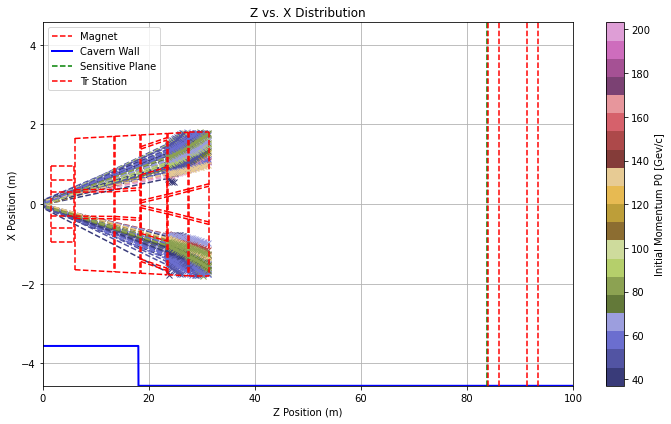

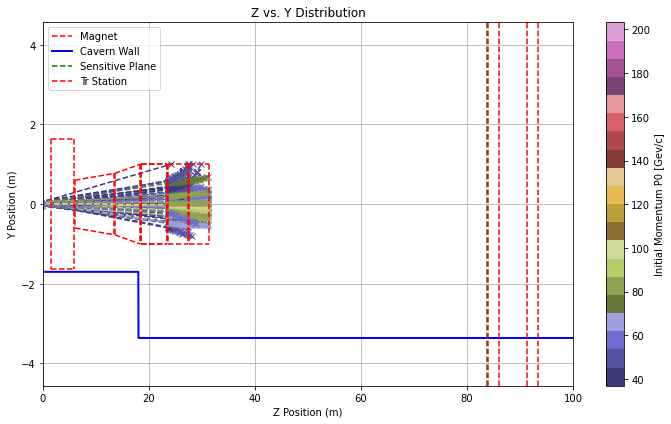

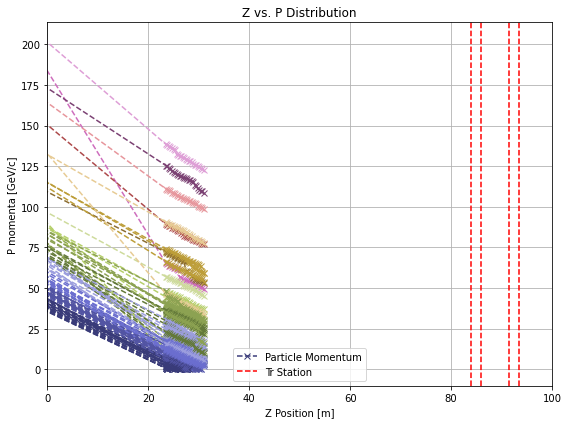

In [11]:
plotter = ParticlePlotterino(X1,Y1,Z_tracks1,P1,Pdg1, magnet_pars=pars_magnet)
plotter.plot_section('x','P')
plotter.plot_section('y','P')
plotter.plot_momenta()


In [ ]:
#def Study_On_Wall_Bouncing()

target_x = -4.56
tolerance = 0.01  # Adjust if necessary

# Find particles that hit X ≈ -4.56 and extract their Z positions
z_values = []
z_values_HsF = []

for item, x_values in X.items():
    indices = np.where(np.isclose(x_values, target_x, atol=tolerance))[0]
    if len(indices) > 0:
        transformed_z = [Z[item][i] + 83.79 - 25.86899902 for i in indices]
        z_values.extend(transformed_z)  
        if item in common_elements:
            z_values_HsF.extend(transformed_z)

# Define consistent bins based on overall Z range
num_bins = 30
bin_edges = np.linspace(min(z_values), max(z_values), num_bins + 1)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(z_values, bins=bin_edges, edgecolor='black', alpha=0.7, label="All Particles")
plt.hist(z_values_HsF, bins=bin_edges, edgecolor='red', alpha=0.7, label="Filtered (HsF)")
plt.xlabel("Z Position")
plt.ylabel("Number of Particles")
plt.title(f"Histogram of Z Positions for Particles at X = {target_x}")
plt.legend()
plt.grid(True)
plt.show()

# Output total count
print(f"Number of particles hitting X = {target_x}: {len(z_values)}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

target_x = -4.56
tolerance = 0.01  # Adjust if necessary

# Find particles that hit X ≈ -4.56 and extract their Z positions and P values
z_values = []
p_values = []
z_values_HsF = []
p_values_HsF = []

for item, x_values in X.items():
    indices = np.where(np.isclose(x_values, target_x, atol=tolerance))[0]
    
    if len(indices) > 0:
        indices = indices[0]
        if Z[item][indices] > 84 -83.79 + 25.86899902: continue
        # Transform Z and collect momentum (P) values
        transformed_z = [Z[item][indices] + 83.79 - 25.86899902]
        z_values.extend(transformed_z)
        p_values.extend([P[item][0]])  # Use the first P value

        if item in common_elements:
            z_values_HsF.extend(transformed_z)
            p_values_HsF.extend([P[item][0]])  # Use the first P value

# Define consistent bins for Z and P values
num_bins = 40
z_bin_edges = np.linspace(min(z_values), max(z_values), num_bins + 1)
p_bin_edges = np.linspace(min(p_values), max(p_values), num_bins + 1)

# Create subplots with shared X-axis
fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True, gridspec_kw={'hspace': 0.01})

# Plot 2D histogram (Z vs P) without HsF filter
hist1 = axs[0].hist2d(z_values, p_values, bins=[z_bin_edges, p_bin_edges], cmap='viridis', cmin=1)
fig.colorbar(hist1[3], ax=axs[0], label='number of bouncing particle without HsF filter')
axs[0].set_ylabel("Initial Momentum (P0) [GeV/c]")
axs[0].set_title(f"2D Histogram of Z vs P for Particles at X = {target_x} m")
axs[0].grid(True)

# Plot 2D histogram (Z vs P) with HsF filter
hist2 = axs[1].hist2d(z_values_HsF, p_values_HsF, bins=[z_bin_edges, p_bin_edges], cmap='inferno', cmin=1)
fig.colorbar(hist2[3], ax=axs[1], label='number of bouncing particle with HsF filter')
axs[1].set_xlabel("Z Position")
axs[1].set_ylabel("Initial Momentum (P0) [GeV/c]")
#axs[1].set_title(f"2D Histogram of Z vs P for Particles at X = {target_x} m (HsF filter)")
axs[1].grid(True)

# Show the final plot
plt.show()

# Output total count
print(f"Number of particles hitting X = {target_x}: {len(z_values)}")
print(f"Number of filtered (HsF) particles hitting X = {target_x}: {len(z_values_HsF)}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

target_x = -4.56
tolerance = 0.01  # Adjust if necessary

# Find particles that hit X ≈ -4.56 and extract their Z positions and P values
z_values = []
p_values = []
p_values_0 = []
z_values_HsF = []
p_values_HsF = []
p_values_HsF_0 = []
p_values_HsF_after = []

for item, x_values in X.items():
    indices = np.where(np.isclose(x_values, target_x, atol=tolerance))[0]
    
    
    if len(indices) > 0:
        
        indices = indices[0]
        if Z[item][indices] > 84 -83.79 + 25.86899902: continue
        # Transform Z and collect momentum (P) values
        transformed_z = [Z[item][indices] + 83.79 - 25.86899902 ]
        z_values.extend(transformed_z)
        p_values.extend([P[item][indices]])  # Add corresponding momentum values
        p_values_0.extend([P[item][0]])  # Add corresponding momentum values

        if item in common_elements:
            z_values_HsF.extend(transformed_z)
            p_values_HsF.extend([P[item][indices]])  # Add corresponding momentum values
            p_values_HsF_0.extend([P[item][0]])  # Add corresponding momentum values
            p_values_HsF_after.extend([P[item][indices+1]])
# Define consistent bins for Z and P values
num_bins = 50
z_bin_edges = np.linspace(min(z_values), max(z_values), num_bins + 1)
p_bin_edges = np.linspace(min(p_values), max(p_values), num_bins + 1)

# Plot 2D histogram (Z vs P)
plt.figure(figsize=(10, 6))
plt.hist2d(z_values, p_values, bins=[z_bin_edges, p_bin_edges], cmap='viridis', alpha=1, cmin=1)
plt.colorbar(label='Frequency')  # Add color bar to show frequency scale
plt.xlabel("Z Position")
plt.ylabel("Momentum (P) [GeV/c] just before hitting")
plt.title(f"2D Histogram of Z vs P for Particles at X = {target_x}")
plt.grid(True)

# Overlay filtered (HsF) particles in the same 2D histogram
#plt.hist2d(z_values_HsF, p_values_HsF, bins=[z_bin_edges, p_bin_edges], cmap='Reds', alpha=0.5, cmin=1)

plt.show()

# Define consistent bins for Z and P values
num_bins = 50
z_bin_edges = np.linspace(min(z_values), max(z_values), num_bins + 1)
p_bin_edges = np.linspace(min(p_values_HsF_after), max(p_values_HsF_after), num_bins + 1)

# Plot 2D histogram (Z vs P)
plt.figure(figsize=(10, 6))
plt.hist2d(z_values_HsF, p_values_HsF_after, bins=[z_bin_edges, p_bin_edges], cmap='inferno', alpha=1, cmin=1)
plt.colorbar(label='Frequency')  # Add color bar to show frequency scale
plt.xlabel("Z Position")
plt.ylabel("Initial Momentum (P0) [GeV/c]")
plt.title(f"2D Histogram of Z vs P for Particles at X = {target_x}")
plt.ylim(min(p_values_HsF_after), max(p_values_HsF_after))
plt.grid(True)

plt.show()

# Output total count
print(f"Number of particles hitting X = {target_x}: {len(z_values)}")
print(f"Number of filtered (HsF) particles hitting X = {target_x}: {len(z_values_HsF)}")


